<a href="https://colab.research.google.com/github/dsynderg/CS-180-assignments/blob/main/08_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/rhodes-byu/cs-stat-180/blob/main/labs/08-clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><p><b>After clicking the "Open in Colab" link, copy the notebook to your own Google Drive before getting started, or it will not save your work</b></p>

One of the most straightforward tasks we can perform on a data set without labels is to find groups of data in our dataset which are similar to one another -- what we call clusters.

K-Means is one of the most popular "clustering" algorithms. K-means stores k centroids that it uses to define clusters. A point is considered to be in a particular cluster if it is closer to that cluster's centroid than any other centroid.

K-Means finds the best centroids by alternating between (1) assigning data points to clusters based on the current centroids (2) chosing centroids (points which are the center of a cluster) based on the current assignment of data points to clusters.

## Dataset: MNIST

### MNIST dataset — a brief overview

**Introduction**
The MNIST (Modified National Institute of Standards and Technology) dataset is a widely used benchmark in machine learning. It contains images of handwritten digits and is often used to teach and test classification and clustering techniques.

**Description**
- Type: Handwritten digit images  
- Size: 70,000 grayscale images (28 × 28 pixels)  
  - Training set: 60,000 images  
  - Test set: 10,000 images  
- Classes: 10 (digits 0–9)  
- Format: Each example is a flattened 784-dimensional vector (28×28 pixels) or a 28×28 image with pixel values in [0, 255].  

**Why use MNIST?**
- It is commonly used as a 'toy' dataset in machine learning.
- Simple and well-structured, so students can focus on methods rather than data cleaning.
- Large enough to illustrate practical issues (scaling, dimensionality reduction, speed) but small enough to run on a laptop when sampled.

**Accessing MNIST**
Use scikit-learn's `fetch_openml` to download the MNIST dataset:

```python
        from sklearn.datasets import fetch_openml
        mnist = fetch_openml('mnist_784', version=1, parser='auto')
        X, y = mnist['data'], mnist['target']
```

Format returned by `fetch_openml('mnist_784')`:
- `X`: a table-like object with 70,000 rows and 784 columns; each row is a flattened 28×28 image (pixels ordered 0...783). Pixel values are typically in the range 0–255.  
- `y`: labels for each row (digits 0–9), often returned as strings; convert to integers with `y = y.astype(int)` if desired.  
  

Quick note: to visualize a row as an image use: `X.iloc[i].values.reshape(28,28)` (or `X.values[i].reshape(28,28)`), then display with `plt.imshow(...)`.

In [3]:
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
import seaborn as sns

# Set global random seed for the notebook
np.random.seed(42)

In [4]:
# Load MNIST dataset
mnist = fetch_openml('mnist_784', version = 1, parser = 'auto')
X, y = mnist['data'], mnist['target']

The MNIST digits in this set are flattened arrays of 784 pixels. We can reshape them to 28x28 pixels and plot them using matplotlib.

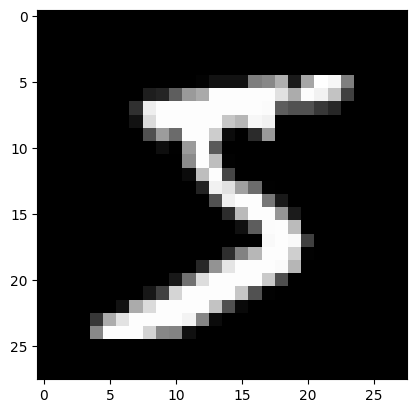

In [11]:
image = X.iloc[0, :].values.reshape((28, 28))
plt.imshow(image, cmap='gray')

### 1. Preparing the Data

a. Using the full dataset, *normalize* each image so that the minimum value is 0, and the maximum is 1. This is a standard practice for image datasets.  


In [5]:
x = X/(255+1e-8)

b. Get a random sample of 10% of the data. The full dataset may take a while to run some of the below methods.

In [1]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

### 2. Fitting k-Means

a. Using the MNIST subset, determine the optimal k value for k-means according to the WCSS elbow method. Use a range of k-values from 2 - 15. (Hint: The plot will not be cut and dry like some of the class examples; just use your best judgement!)

In [14]:
wcss = []
for i in range(2,16):
  kmeans = KMeans(n_clusters=i, random_state=42)
  kmeans.fit(X_train)
  wcss.append(kmeans.inertia_)

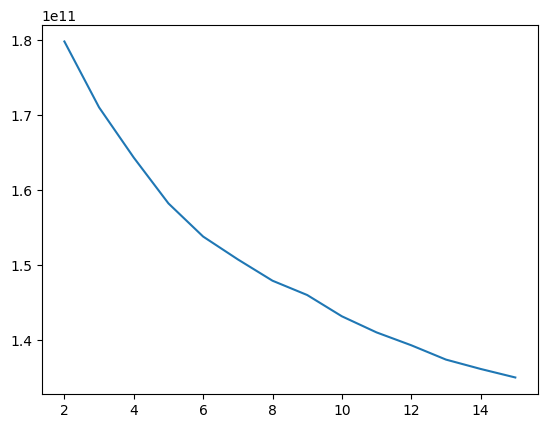

In [15]:
plt.plot(range(2,16),wcss)
plt.show()

b. Fit a k-means model with the optimal k value.

In [17]:
kmeans = KMeans(n_clusters=10, random_state=42,n_init=10)
kmeans.fit(X_train)



KMeans(n_clusters=10, n_init=10, random_state=42)

c. High-dimensional data—like MNIST digit images with 784 pixels—are hard to visualize.  
**Dimensionality reduction** helps us find a lower-dimensional view that keeps important patterns.

**Principal Component Analysis (PCA)** is a simple and fast method that finds directions of maximum variation in the data. By keeping only the top two directions, we can make a 2D version of our data that’s easy to plot.

Use **PCA** to reduce the MNIST data to **2 dimensions** (`n_components=2`).  
Then make a **scatterplot** of the 2D data and **color the points by their k-means cluster labels**. Use the Dark2 colormap to help distingish the colors. It will also be helpful to shrink the point size (e.g., s = 0.5).

📘 **Hint:** Use [`sklearn.decomposition.PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).


In [22]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(X_train)

In [39]:
labels = kmeans.predict(X_train)
print(labels)

[9 7 0 ... 0 6 1]


In [50]:
y_train.values.astype(int)

array([5, 4, 8, ..., 1, 0, 0])

In [37]:
print(y_train.values)

['5', '4', '8', '0', '2', ..., '6', '6', '1', '0', '0']
Length: 56000
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']


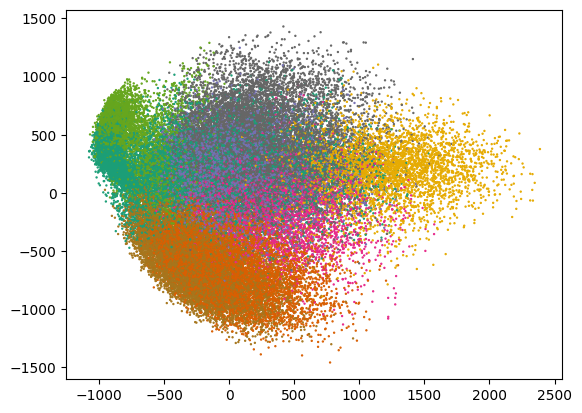

In [23]:
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=labels, cmap='Dark2', s=0.5)
plt.show()

d. Create two side-by-side scatterplots using the PCA representation (first two principal components) using plt.subplots. Color the first fig according to the true labels and the second according to k-means cluster labels. Be sure to include proper figure titles and a legend.

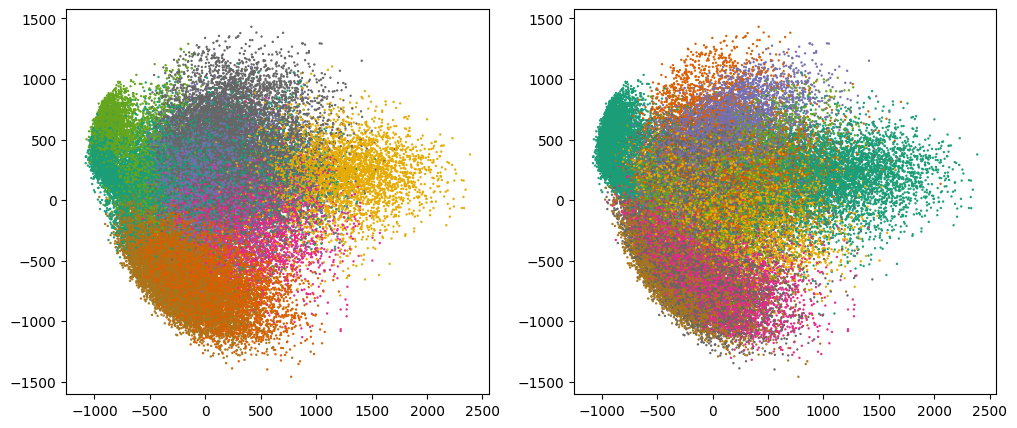

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

scatter1= axes[0].scatter(x_pca[:, 0], x_pca[:, 1], c=labels, cmap='Dark2', s=0.5)
scatter2= axes[1].scatter(x_pca[:, 0], x_pca[:, 1], c=y_train.values.astype(int), cmap='Dark2', s=0.5)
plt.show()

e. Describe the fit. Does this align with your expectation? (Note: The specific color used for the clusters and labels will not align, but do you see some of the same patterns emerge?)

this does make sense. there is a lot of overlap between the two figures. There is a very large amount of similarity. the colors do overlap, but that is to be expected with pca

f. Display the cluster centroids as images in a grid using subplots. What digits do they most resemble?

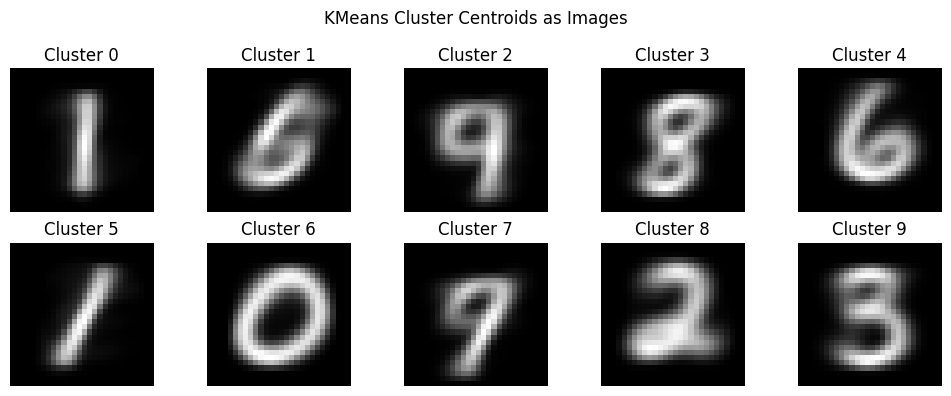

In [56]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.flatten()
centroids = kmeans.cluster_centers_.reshape(10, 28, 28)

for i in range(10):
    axes[i].imshow(centroids[i], cmap='gray')
    axes[i].set_title(f"Cluster {i}")
    axes[i].axis('off')


plt.suptitle("KMeans Cluster Centroids as Images")
plt.tight_layout()
plt.show()


### 3. Hierarchical Clustering
Here you will be performing hierarchical clustering on a smaller data subset.

Here you will be comparing linkage methods and metrics. Use the following linkage/metric combinations:

| Linkage Method | Metrics              |
|---------------|----------------------|
| Ward         | Euclidean            |
| Complete     | Euclidean, Cosine |

a. Get a subset of 10% of your original subset (you should have 700 points).

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99, random_state=42)

In [7]:
len(X_train)

700

b. Fit hierarhiccal clustering with 10 clusters for each combination and store the silhouette scores.

In [11]:
model = AgglomerativeClustering(n_clusters=10, linkage='ward',metric="euclidean")
labels = model.fit_predict(X_train)
ward_score = silhouette_score(X_train,labels)

In [16]:
model = AgglomerativeClustering(n_clusters=10, linkage='complete',metric="euclidean")
labels = model.fit_predict(X_train)
CE_score = silhouette_score(X_train,labels)

In [13]:
model = AgglomerativeClustering(n_clusters=10, linkage='complete',metric="cosine")
labels = model.fit_predict(X_train)
CC_score = silhouette_score(X_train,labels)

c. According to the silhouette scores, which combination is best?

In [14]:
print(ward_score)
print(CE_score)
print(CC_score)

0.040672943311682176
0.05479648356465329
0.01632327871732904


the best metric would be the complete lingage with a euclidean metric becasue it has the highest score

### 4. Visualizing Clustered Digits

\a. Pick one of the cluster labels from your best models (k-means or HC). Select a random subset of 20 points belonging to that cluster.  

---



In [15]:
# Generate random labels for the user's request
random_indices = np.random.choice(len(labels), 20, replace=False)
random_20_labels = labels[random_indices]
print(random_20_labels)

[0 7 7 4 2 7 9 3 1 5 2 3 6 6 6 3 9 0 6 8]


b. Using subplots (4 rows, 5 columns), plot the 20 digit images.  

<Figure size 640x480 with 0 Axes>

c. Comment on the clustered points (e.g., do they look similar?, are the representing the same digit?, etc.)